## Visualizations


In [100]:
import torch
import matplotlib.pyplot as plt
from IPython.display import Audio

import util
from config import Config
from data import (
    AudioDataloader,
    Librispeech,
    MSPPodcast,
    librispeech_collate_fn,
    MelSpectrogramFixed,
)
from models import (
    VQVAE,
    MetaStyleSpeech,
    WavenetDecoder,
    SourceFilterEncoder,
    HifiGAN
)

## Configurations

In [101]:
CONFIG_NAME = "config.yaml"
TESTING_DATASET = "librispeech"  # "msp-podcast"

# set default device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load data

In [102]:
cfg = Config.from_yaml(CONFIG_NAME)

if TESTING_DATASET == "librispeech":
    dataset = Librispeech("dev-clean", "LibriSpeech")
    dataloader = AudioDataloader(
        dataset=dataset, cfg=cfg, collate_fn=librispeech_collate_fn
    )
elif TESTING_DATASET == "msp-podcast":
    dataset = MSPPodcast(cfg.data.dataset, split="development")
    dataloader = AudioDataloader(dataset=dataset, cfg=cfg)
else:
    raise ValueError(f"Unknown dataset: {TESTING_DATASET}")

# Source-Filter Encoder

## Load models

In [103]:
pitch_encoder = VQVAE(cfg.models.src_ftr_encoder.pitch_encoder)
util.load_model(pitch_encoder, "vqvae.pth")
speaker_encoder = MetaStyleSpeech(cfg.models.src_ftr_encoder.speaker_encoder)
util.load_model(speaker_encoder, "metastylespeech.pth")
decoder = WavenetDecoder(cfg.models.src_ftr_encoder)
util.load_model(decoder, "wavenet_decoder.pth")

src_ftr_encoder = SourceFilterEncoder(
    cfg.models.src_ftr_encoder,
    pitch_encoder=pitch_encoder,
    speaker_encoder=speaker_encoder,
    decoder=decoder,
)
src_ftr_encoder.requires_grad_(False)
src_ftr_encoder.to(device)
src_ftr_encoder.eval()
print("Models loaded successfully.")

Models loaded successfully.


## Perform forward pass of the Source-Filter encoder

In [104]:
mel_transform = MelSpectrogramFixed(cfg.data.mel_transform).to(device)
x, x_length = next(iter(dataloader))
x = x.to(device)
x_length = x_length.to(device)
x_mel = mel_transform(x)
x_mask = util.sequence_mask(x_length, x_mel.size(2)).to(x_mel.dtype)

src_mel, ftr_mel = src_ftr_encoder(x, x_mel, x_mask)
y_mel = src_mel + ftr_mel

## Visualize the mel-spectrograms

In [105]:
def plot_mel(
    mels: torch.Tensor | list[torch.Tensor],
    title: str = "Mel-spectrogram",
    subtitle: list[str] = None,
) -> None:
    """Plot mel-spectrograms."""
    if not isinstance(mels, list):
        mels = [mels]
    n_mels = len(mels)
    fig, axes = plt.subplots(1, n_mels, figsize=(5 * n_mels, 5))
    if n_mels == 1:
        axes = [axes]
    for i, mel in enumerate(mels):
        axes[i].imshow(mel[0].detach().cpu().numpy(), aspect="auto", origin="lower")
        axes[i].set_title(subtitle[i] if subtitle else f"{title} {i+1}")
        axes[i].set_xlabel("Frames")
        axes[i].set_ylabel("Channels")
    plt.tight_layout()
    plt.show()

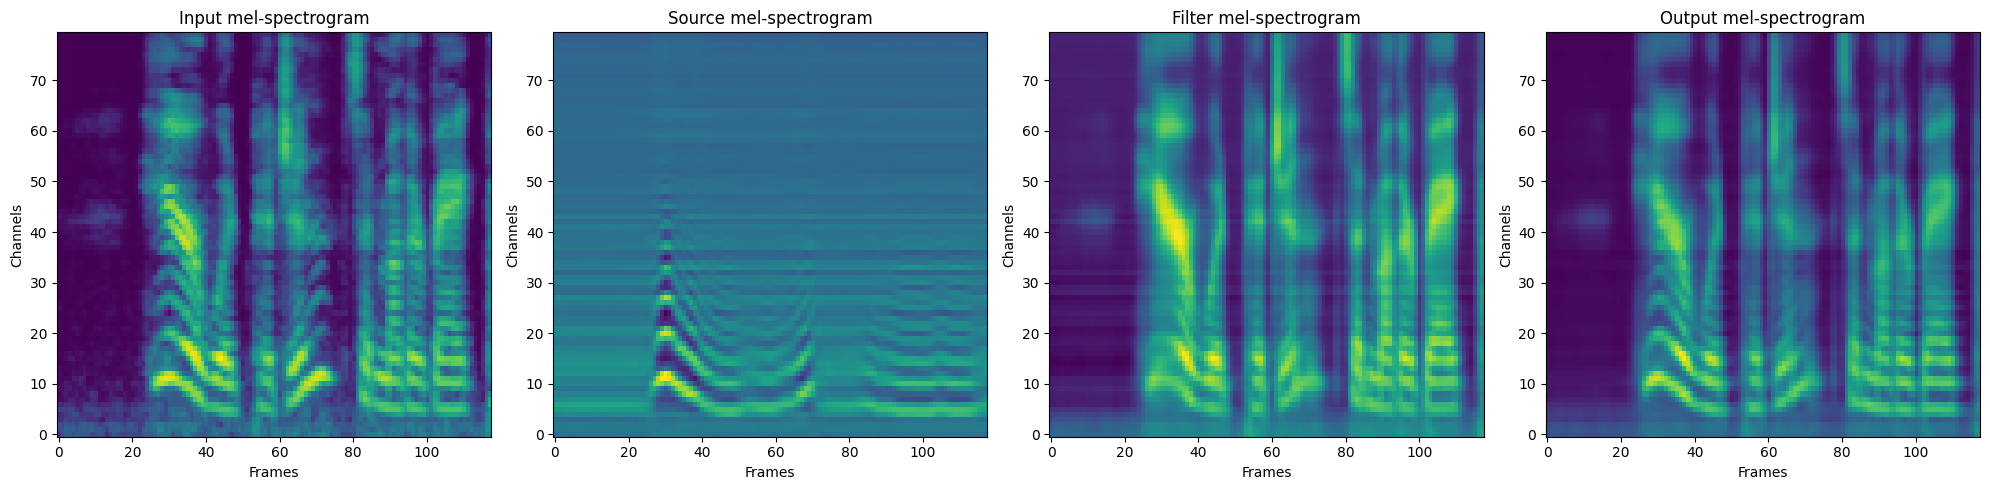

In [106]:
plot_mel(
    title="Source-Filter Encoder",
    mels=[x_mel, src_mel, ftr_mel, y_mel],
    subtitle=[
        "Input mel-spectrogram",
        "Source mel-spectrogram",
        "Filter mel-spectrogram",
        "Output mel-spectrogram",
    ]
)


## Vocode the mel-spectrograms

In [107]:
vocoder = HifiGAN(cfg.models.vocoder)
vocoder.requires_grad_(False)
vocoder.to(device)
util.load_model(vocoder, "hifigan.pth")
print("Vocoder loaded successfully.")

Vocoder loaded successfully.


### Original audio

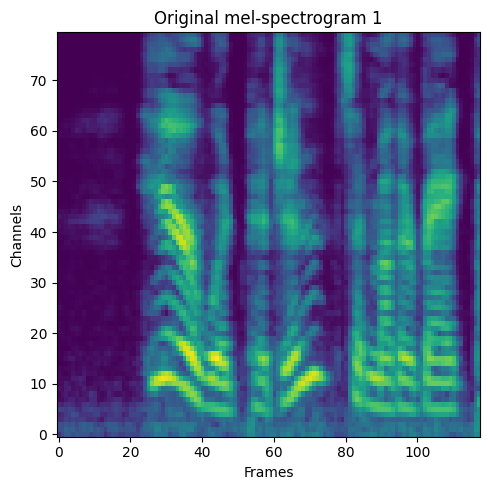

In [108]:
plot_mel(x_mel, title="Original mel-spectrogram")
Audio(x[0].detach().cpu().numpy(), rate=cfg.data.dataset.sampling_rate)

### Vocoded from the input mel-spectrogram

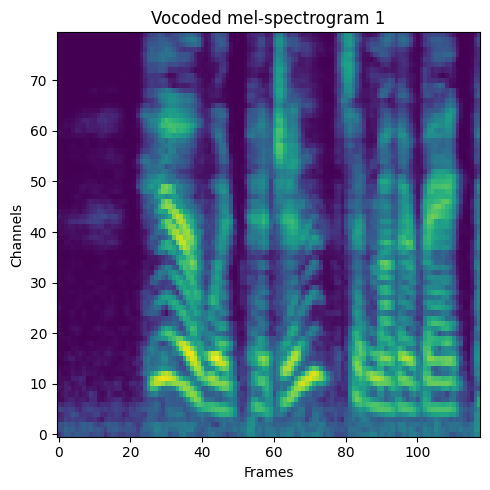

In [109]:
voice = vocoder.infer(x_mel)
plot_mel(x_mel, title="Vocoded mel-spectrogram")
Audio(voice[0].detach().cpu().numpy(), rate=cfg.data.dataset.sampling_rate)

### Vocoded from the source mel-spectrogram

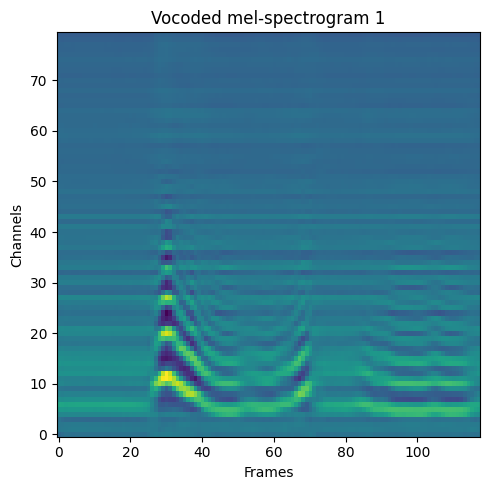

In [110]:
voice = vocoder.infer(src_mel)
plot_mel(src_mel, title="Vocoded mel-spectrogram")
Audio(voice[0].detach().cpu().numpy(), rate=cfg.data.dataset.sampling_rate)

### Vocoded from the filter mel-spectrogram

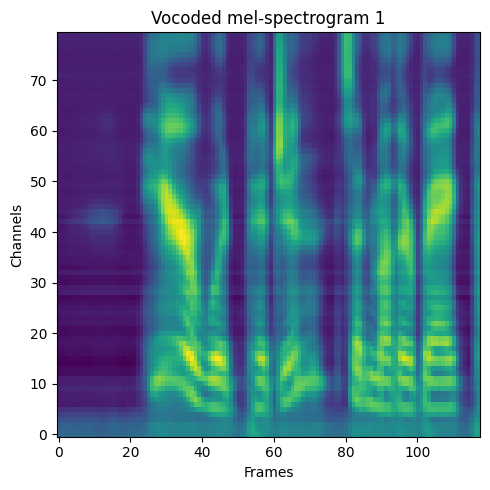

In [111]:
voice = vocoder.infer(ftr_mel)
plot_mel(ftr_mel, title="Vocoded mel-spectrogram")
Audio(voice[0].detach().cpu().numpy(), rate=cfg.data.dataset.sampling_rate)

### Vocoded from the output mel-spectrogram

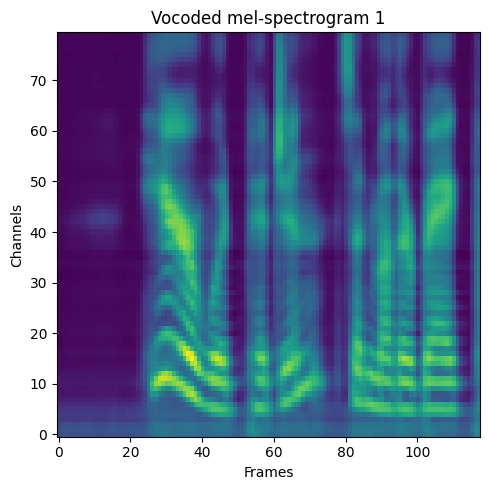

In [112]:
voice = vocoder.infer(y_mel)
plot_mel(y_mel, title="Vocoded mel-spectrogram")
Audio(voice[0].detach().cpu().numpy(), rate=cfg.data.dataset.sampling_rate)

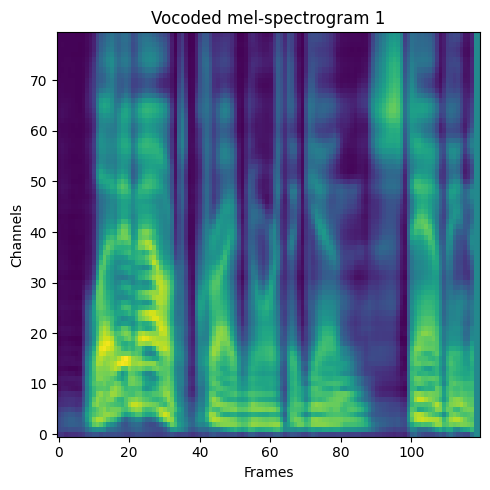

In [113]:
root = util.get_root_path()
testdata_path = root / "src" / "tests" / "testdata"

mel_diff = torch.load(testdata_path / "diffusion_enc_out.pth", weights_only=True)
voice = vocoder.infer(mel_diff.to(device))
plot_mel(mel_diff, title="Vocoded mel-spectrogram")
Audio(voice[0].detach().cpu().numpy(), rate=cfg.data.dataset.sampling_rate)

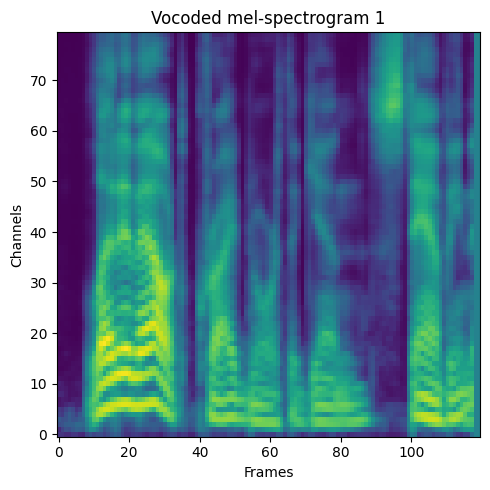

In [114]:
mel_diff = torch.load(testdata_path / "diffusion_test.pth", weights_only=True)
voice = vocoder.infer(mel_diff.to(device))
plot_mel(mel_diff, title="Vocoded mel-spectrogram")
Audio(voice[0].detach().cpu().numpy(), rate=cfg.data.dataset.sampling_rate)